# Loss and Regularization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as nplin
from cs771 import plotData as pd
from cs771 import optLib as opt
from sklearn import linear_model
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import random

**Loading Benchmark Datasets using _sklearn_**: the _sklearn_ library, along with providing methods for various ML problems like classification, regression and clustering, also gives the facility to download various datasets. We will use the _Boston Housing_ dataset that requires us to predict house prices in the city of Boston using 13 features such as crime rates, pollution levels, education facilities etc. Check this [[link]](https://scikit-learn.org/stable/datasets/index.html#boston-dataset) to learn more.

**Caution**: when executing the dataset download statement for the first time, sklearn will attempt to download this dataset from an internet source. Make sure you have a working internet connection at this point otherwise the statement will fail. Once you have downloaded the dataset once, it will be cached and you would not have to download it again and again.

In [3]:
from sklearn.datasets import load_boston
(X, y) = load_boston( return_X_y=True )
(n, d) = X.shape
print( "This dataset has %d data points and %d features" % (n,d) )
print( "The mean value of the (real-valued) labels is %.2f" % np.mean(y) )

This dataset has 506 data points and 13 features
The mean value of the (real-valued) labels is 22.53


**Experiments with Ridge Regression**: we first use rigde regression (that uses the least squares loss and $L_2$ regularization) to try and solve this problem. We will try out a variety of regularization parameters ranging across 15 orders of magnitude from $10^{-4}$ all the way to $10^{11}$. Note that as the regularization parameter increases, the model norm drops significantly so that at extremely high levels of regularization, the learnt model is almost a zero vector. Naturally, such a trivial model offers poor prediction hence, beyond a point, increasing the regularization parameter decreases prediction performance. We measure prediction performance in term of _mean absolute error_ (shortened to MAE).

**Regularization Path**: the concept of a regularization path traces the values different coordinates of the model take when the problem is solved using various values of the regularization parameter. Note that initially, when there is very feeble regularization (say $\alpha = 10^{-4}$), model coordinates take large magnitude values, some positive, others negative. However, as regularization increases, all model coordinate values _shrink_ towards zero.

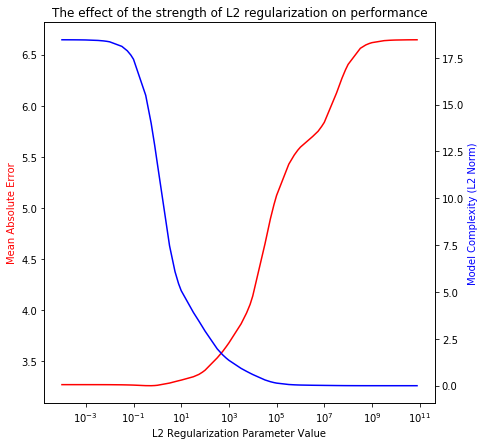

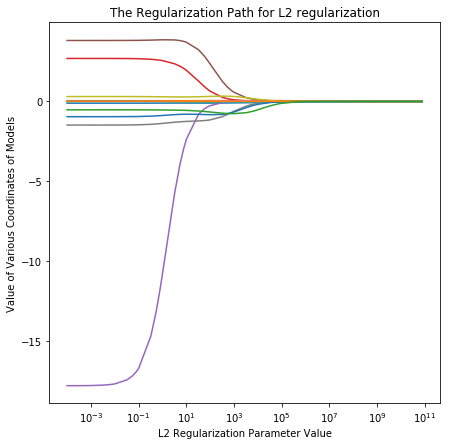

In [4]:
alphaVals = np.concatenate( [np.linspace( 1e-4 * 10**i, 1e-4 * 10**(i+1), num = 5 )[:-1] for i in range(15)] )
MAEVals = np.zeros_like( alphaVals )
modelNorms = np.zeros_like( alphaVals )
models = np.zeros( (X.shape[1], len(alphaVals)) )

for i in range( len(alphaVals) ):
    reg = linear_model.Ridge( alpha = alphaVals[i] )
    reg.fit( X, y )
    w = reg.coef_
    b = reg.intercept_
    MAEVals[i] = np.mean( np.abs( X.dot(w) + b - y ) )
    modelNorms[i] = nplin.norm( w, 2 )
    models[:,i] = w

bestRRMAENoCorr = min( MAEVals )

fig = pd.getFigure( 7, 7 )
ax = plt.gca()
ax.set_title( "The effect of the strength of L2 regularization on performance" )
ax.set_xlabel( "L2 Regularization Parameter Value" )
ax.set_ylabel( "Mean Absolute Error", color = "r" )
ax.semilogx( alphaVals, MAEVals, color = 'r', linestyle = '-' )
ax2 = ax.twinx()
ax2.set_ylabel( "Model Complexity (L2 Norm)", color = "b" )
ax2.semilogx( alphaVals, modelNorms, color = 'b', linestyle = '-' )

fig2 = pd.getFigure( 7, 7 )
plt.figure( fig2.number )
plt.title( "The Regularization Path for L2 regularization" )
plt.xlabel( "L2 Regularization Parameter Value" )
plt.ylabel( "Value of Various Coordinates of Models" )
for i in range(d):
    plt.semilogx( alphaVals, models[i,:] )

**Robust Regression**: we will now investigate how to deal with cases when the data is corrupted. We will randomly choose 25% of the data points and significantly change their labels (i.e. $y$ values). We will note that ridge regression fails to offer a decent solution no matter what value of the regression parameter we choose. The best MAE offered by ridge regression in this case is 8.1 whereas it was around 3.2 when data was not corrupted. Clearly $L_2$ regularization is not a good option when data is maliciously or adversarially corrupted.

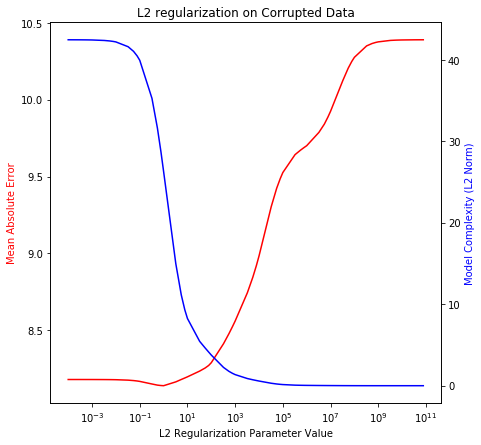

In [5]:
# How many points do we want to corrupt?
k = int( 0.25 * n )
corr = np.zeros_like( y )
idx_corr = np.random.permutation( n )[:k]

# What diff do we want to introduce in the labels of the corrupted data points?
corr[idx_corr] = 30
y_corr = y + corr

MAEVals = np.zeros_like( alphaVals )
modelNorms = np.zeros_like( alphaVals )

for i in range( len(alphaVals) ):
    reg = linear_model.Ridge( alpha = alphaVals[i] )
    reg.fit( X, y_corr )
    w = reg.coef_
    b = reg.intercept_
    MAEVals[i] = np.mean( np.abs( X.dot(w) + b - y ) )
    modelNorms[i] = nplin.norm( w, 2 )

bestRRMAE = min( MAEVals )

fig3 = pd.getFigure( 7, 7 )
ax = plt.gca()
ax.set_title( "L2 regularization on Corrupted Data" )
ax.set_xlabel( "L2 Regularization Parameter Value" )
ax.set_ylabel( "Mean Absolute Error", color = "r" )
ax.semilogx( alphaVals, MAEVals, color = 'r', linestyle = '-' )
ax2 = ax.twinx()
ax2.set_ylabel( "Model Complexity (L2 Norm)", color = "b" )
ax2.semilogx( alphaVals, modelNorms, color = 'b', linestyle = '-' )

**Alternating Minimization for Robust Regression**: a simple heuristic that works well in such corrupted data settings is to learn the model and try to identify the subset of the data that is corrupted simultaneously. A variant of this heuristic, as presented in the _TORRENT_ algorithm is implemented below. At each time step, this method takes an existing model and postulates that data points with high residuals with respect to this model may be corrupted and sets them aside. Ridge regression is then carried out with the rest of the data points to update the model.

The results show that this simple heuristic not only offers a much better MAE (of around 3.2, the same that ridge regression offered when executed with clean data) but that the method is able to identify most of the data points that were corrupted. The method converges in only a couple of iterations.

**Reference**\
Kush Bhatia, Prateek Jain and P.K., _Robust Regression via Hard Thresholding_ , Proceedings of the 29th Annual Conference on Neural Information Processing Systems (NIPS), 2015.

(108.0, 126)

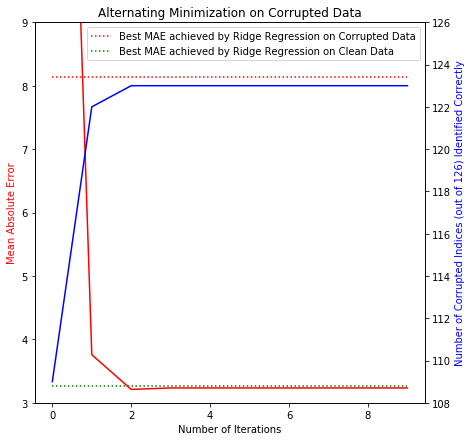

In [6]:
# How many iterations do we wish to run the algorithm
horizon = 10
MAEVals = np.zeros( (horizon,) )
suppErrVals = np.zeros( (horizon,) )

# Initialization
w = np.zeros( (d,) )
b = 0
reg = linear_model.Ridge( alpha = 0.005 )

# Find out how many of the corrupted data points were correctly identified by the algorithm
def getSupportIden( idx, idxAst ):
    return len( set(idxAst).intersection( set(idx) ) )

# Implement the TORRENT algorithm
for t in range( horizon ):
    MAEVals[t] = np.mean( np.abs( X.dot(w) + b - y ) )
    
    # Find out the data points with largest residual -- these maybe the corrupted points
    res = np.abs( X.dot(w) + b - y_corr )
    idx_sorted = np.argsort( res )
    idx_clean_hat = idx_sorted[0:n-k]
    idx_corr_hat = idx_sorted[-k:]
    suppErrVals[t] = getSupportIden( idx_corr, idx_corr_hat )
    
    # The points with low residuals are used to update the model
    XClean = X[idx_clean_hat,:]
    yClean = y_corr[idx_clean_hat]
    reg.fit( XClean, yClean )
    w = reg.coef_
    b = reg.intercept_    

fig4 = pd.getFigure( 7, 7 )
plt.plot( np.arange( horizon ), bestRRMAE * np.ones_like(suppErrVals), color = 'r', linestyle = ':', label = "Best MAE achieved by Ridge Regression on Corrupted Data" )
plt.plot( np.arange( horizon ), bestRRMAENoCorr * np.ones_like(suppErrVals), color = 'g', linestyle = ':', label = "Best MAE achieved by Ridge Regression on Clean Data" )
plt.legend()
ax = plt.gca()
ax.set_title( "Alternating Minimization on Corrupted Data" )
ax.set_xlabel( "Number of Iterations" )
ax.set_ylabel( "Mean Absolute Error", color = "r" )
ax.plot( np.arange( horizon ), MAEVals, color = 'r', linestyle = '-' )
plt.ylim( np.floor(min(MAEVals)),  np.ceil(bestRRMAE) )
ax2 = ax.twinx()
ax2.set_ylabel( "Number of Corrupted Indices (out of %d) Identified Correctly" % k, color = "b" )
ax2.yaxis.set_major_locator( MaxNLocator( integer = True ) )
ax2.plot( np.arange( horizon ), suppErrVals, color = 'b', linestyle = '-' )
plt.ylim( min(suppErrVals)-1, k )

**Spurious Features present a Sparse Recovery Problem**: in this experiment we add 500 new features to the dataset (with the new features containing nothing but pure random white noise), taking the total number of features to 513 which is greater than the total number of data points which is 506. Upon executing ridge regression on this dataset, we find something very surprising. We find that at low levels of regularization, the method offers almost zero MAE!

The above may seem paradoxical since the new features were white noise and had nothing informative to say about the problem. What happened was that these new features increased the power of the linear model and since there was not enough data, ridge regression used these new features to artificially reduce the error. This is clear from the regularization path plot.

Such a model is actually not very useful since it would not perform very well on test data. To do well on test data, the only way is to identify the truly informative features (of which there are only 13). Note that in the error plot, the blue curve demonstrates the amount of weight the model puts on the spurious features. Only when there is heavy regularization (around $\alpha = 10^4$ does the model stop placing large weights on the spurious features and error levels climb to around 3.2, where they were when spurious features were not present. Thus, L2 regularization may not be the best option when there are several irrelevant features.

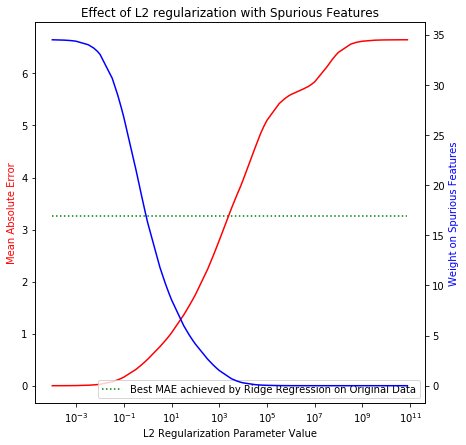

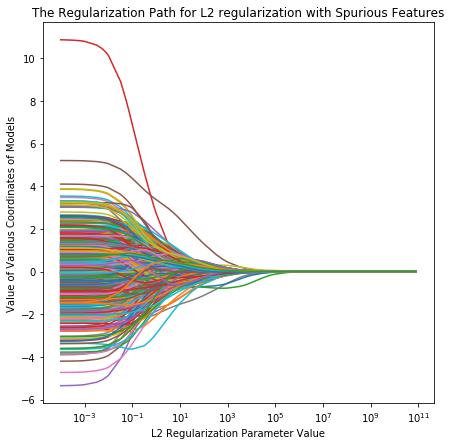

In [7]:
X_spurious = np.random.normal( 0, 1, (n, 500) )
X_extend = np.hstack( (X, X_spurious) )
(n,d) = X_extend.shape

MAEVals = np.zeros_like( alphaVals )
spuriousModelNorms = np.zeros_like( alphaVals )
models = np.zeros( (d, len(alphaVals)) )

for i in range( len(alphaVals) ):
    reg = linear_model.Ridge( alpha = alphaVals[i] )
    reg.fit( X_extend, y )
    w = reg.coef_
    b = reg.intercept_
    MAEVals[i] = np.mean( np.abs( X_extend.dot(w) + b - y ) )
    spuriousModelNorms[i] = nplin.norm( w[13:], 2 )
    models[:,i] = w

fig5 = pd.getFigure( 7, 7 )
plt.plot( alphaVals, bestRRMAENoCorr * np.ones_like(alphaVals), color = 'g', linestyle = ':', label = "Best MAE achieved by Ridge Regression on Original Data" )
plt.legend()
ax = plt.gca()
ax.set_title( "Effect of L2 regularization with Spurious Features" )
ax.set_xlabel( "L2 Regularization Parameter Value" )
ax.set_ylabel( "Mean Absolute Error", color = "r" )
ax.semilogx( alphaVals, MAEVals, color = 'r', linestyle = '-' )
ax2 = ax.twinx()
ax2.set_ylabel( "Weight on Spurious Features", color = "b" )
ax2.semilogx( alphaVals, spuriousModelNorms, color = 'b', linestyle = '-' )

fig6 = pd.getFigure( 7, 7 )
plt.figure( fig6.number )
plt.title( "The Regularization Path for L2 regularization with Spurious Features" )
plt.xlabel( "L2 Regularization Parameter Value" )
plt.ylabel( "Value of Various Coordinates of Models" )
for i in range(d):
    plt.semilogx( alphaVals, models[i,:] )

**LASSO for Sparse Recovery**: the LASSO (Least Absolute Shrinkage and Selection Operator) performs regression using the least squares loss and the $L_1$ regularizer instead. The error plot and the regularization path plots show that LASSO offers a far quicker identification of the spurious features. LASSO is indeed a very popular technique to deal with sparse recovery when we have very less data and suspect that there may be irrelevant features.

c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.64568703437649, tolerance: 4.2716295415019765
  positive)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.65675860297509, tolerance: 4.2716295415019765
  positive)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.221390390589, tolerance: 4.2716295415019765
  positive)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_

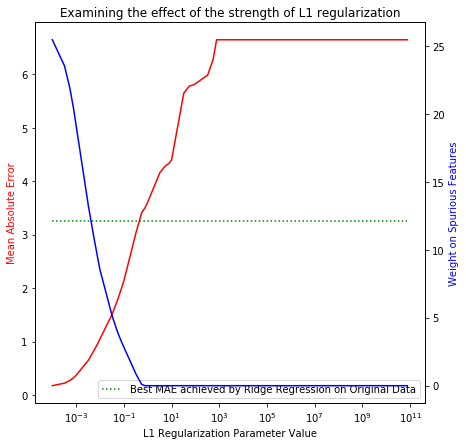

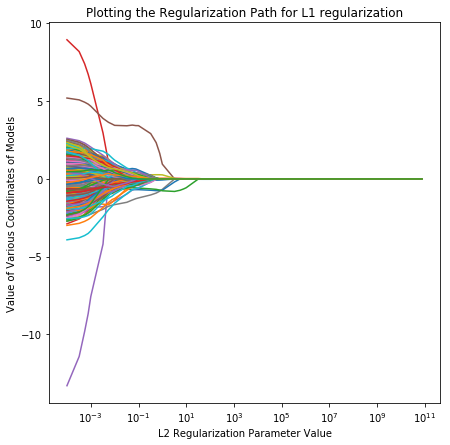

In [8]:
MAEVals = np.zeros_like( alphaVals )
spuriousModelNorms = np.zeros_like( alphaVals )
models = np.zeros( (X_extend.shape[1], len(alphaVals)) )

for i in range( len(alphaVals) ):
    reg = linear_model.Lasso( alpha = alphaVals[i] )
    reg.fit( X_extend, y )
    w = reg.coef_
    b = reg.intercept_
    MAEVals[i] = np.mean( np.abs( X_extend.dot(w) + b - y ) )
    spuriousModelNorms[i] = nplin.norm( w[13:], 2 )
    models[:,i] = w

fig5 = pd.getFigure( 7, 7 )
plt.plot( alphaVals, bestRRMAENoCorr * np.ones_like(alphaVals), color = 'g', linestyle = ':', label = "Best MAE achieved by Ridge Regression on Original Data" )
plt.legend()
ax = plt.gca()
ax.set_title( "Examining the effect of the strength of L1 regularization" )
ax.set_xlabel( "L1 Regularization Parameter Value" )
ax.set_ylabel( "Mean Absolute Error", color = "r" )
ax.semilogx( alphaVals, MAEVals, color = 'r', linestyle = '-' )
ax2 = ax.twinx()
ax2.set_ylabel( "Weight on Spurious Features", color = "b" )
ax2.semilogx( alphaVals, spuriousModelNorms, color = 'b', linestyle = '-' )

fig6 = pd.getFigure( 7, 7 )
plt.figure( fig6.number )
plt.title( "Plotting the Regularization Path for L1 regularization" )
plt.xlabel( "L2 Regularization Parameter Value" )
plt.ylabel( "Value of Various Coordinates of Models" )
for i in range(X_extend.shape[1]):
    plt.semilogx( alphaVals, models[i,:] )

**Proximal Gradient Descent to solve LASSO**: we will now implement the proximal gradient descent method to minimize the LASSO objective. The _ProxGD_ method performs a usual gradient step and then applies the _prox operator_ corresponding to the regularizer. For the $L_1$ regularizer $\lambda\cdot\|\cdot\|_1$, the prox operator $\text{prox}_{\lambda\cdot\|\cdot\|_1}$ is simply the so-called _soft-thresholding_ operator described below. If $\mathbf z = \text{prox}_{\lambda\cdot\|\cdot\|_1}(\mathbf x)$, then for all $i \in [d]$, we have
$$
\mathbf z_i = \begin{cases} \mathbf x_i - \lambda & \mathbf x_i > \lambda \\ 0 & |\mathbf x_i| \leq \lambda \\ \mathbf x_i + \lambda & \mathbf x_i < -\lambda \end{cases}
$$
Applying ProxGD to the LASSO problem is often called _ISTA_ (Iterative Soft Thresholding Algorithm) for this reason. Note that at time $t$, if the step length used for the gradient step is $\eta_t$, then the prox operator corresponding to $\text{prox}_{\lambda_t\cdot\|\cdot\|_1}$ is used where $\lambda_t = \eta_t\cdot\lambda$ and $\lambda$ is the regularization parameter in the LASSO problem we are trying to solve. Thus, ISTA requires shrinkage to be smaller if we are also using small step sizes.

To speed up convergence, _acceleration_ techniques (e.g. NAG, Adam) are helpful. We will use a very straightforward acceleration technique which simply sets
$$
\mathbf w^t = \mathbf w^t + \frac {2t}{t+1}\cdot(\mathbf w^t - \mathbf w^{t-1})
$$
In particular, the application of Nesterov's acceleartion i.e. NAG to ISTA gives us the so-called _FISTA_ (Fast ISTA).

There are several steps one can adopt to get better performance
1. Use a line search method to tune the step length instead of using a fixed step length or a regular schedule
1. Perform a better implementation of the acceleration step (which may require additional hyperparameters)
1. The Boston housing problem is what is called _ill-conditioned_. Use method like conjugate gradient descent (beyond the scope of CS771).
1. Use better solvers -- coordinate descent solvers for the Lagrangian dual of the LASSO are known to offer superior performance.

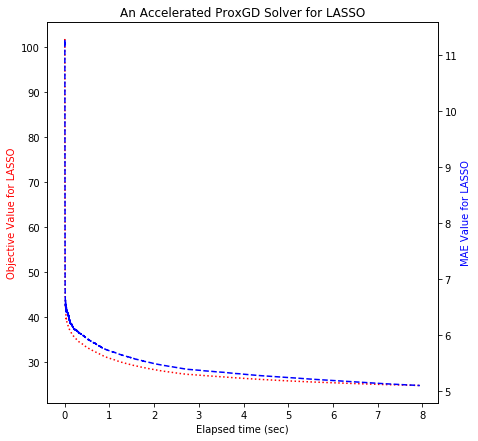

In [9]:
# Get the MAE and LASSO objective 
def getLASSOObj( model ):
    w = model[:-1]
    b = model[-1]
    res = X_extend.dot(w) + b - y
    objVal = alpha * nplin.norm( w, 1 ) + 1/(2*n) * ( nplin.norm( res ) ** 2 )
    MAEVal = np.mean( np.abs( res ) )
    return (objVal, MAEVal)

# Apply the prox operator and also apply acceleration
def doSoftThresholding( model, t ):
    global modelPrev
    w = model[:-1]
    b = model[-1]
    
    # Shrink all model coordinates by the effective value of alpha
    idx = w < 0
    alphaEff = alpha * stepFunc(t)
    w = np.abs(w) - alphaEff
    w[w < 0] = 0
    w[idx] = w[idx] * -1
    model = np.append( w, b )
    
    # Acceleration step improves convergence rate
    model = model + (2*t/(t+1)) * (model - modelPrev)
    modelPrev = model
    
    return model

# Get the gradient to the loss function in LASSO (just the least squares part)
# Note that gradients w.r.t the regularizer are not required in proximal gradient
# This is one reason why they are useful with non-differentiable regularizers
def getLASSOGrad( model, t ):
    w = model[:-1]
    b = model[-1]
    samples = random.sample( range(0, n), B )
    X_ = X_extend[samples,:]
    y_ = y[samples]
    res = X_.dot(w) + b - y_
    grad = np.append( X_.T.dot(res), np.sum(res) )
    return grad/B

# Set hyperparameters and initialize the model
alpha = 1
B = 10
eta = 2e-6
init = np.zeros( (d+1,) )
modelPrev = np.zeros( (d+1,) )

# A constant step length seems to work well here
stepFunc = opt.stepLengthGenerator( "constant", eta )
(modelProxGD, objProxGD, timeProxGD) = opt.doGD( getLASSOGrad, stepFunc, getLASSOObj, init, horizon = 50000, doModelAveraging = True, postGradFunc = doSoftThresholding )
objVals = [objProxGD[i][0] for i in range(len(objProxGD))]
MAEVals = [objProxGD[i][1] for i in range(len(objProxGD))]

fig7 = pd.getFigure( 7, 7 )
ax = plt.gca()
ax.set_title( "An Accelerated ProxGD Solver for LASSO" )
ax.set_xlabel( "Elapsed time (sec)" )
ax.set_ylabel( "Objective Value for LASSO", color = "r" )
ax.plot( timeProxGD, objVals, color = 'r', linestyle = ':' )
ax2 = ax.twinx()
ax2.set_ylabel( "MAE Value for LASSO", color = "b" )
ax2.plot( timeProxGD, MAEVals, color = 'b', linestyle = '--' )